# Detector de Harris

## Imports e Auxiliares
Imports e algumas funções auxiliares: para mostrar imagens, desenhar pontos e gerar um tabuleiro de xadrez

In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def show(cv2_img,title=""):
    """
    Show OpenCV BGR image
    """
    if title:
        plt.title(title)
    plt.imshow(cv.cvtColor(cv2_img, cv.COLOR_BGR2RGB))
    plt.show()
    
def drawPoint(cv2_img, coord, radius=30):
    """
    Draws an small circle in coordinates passed as parameters
    """
    cv.circle(cv2_img, coord, radius, (0,0,255), thickness=-1)

In [3]:
def generate_checkered(sq_size=50, qtd_x=10, qtd_y=10):
    """
    Generate a checkered pattern with specified square height. 
    There will be 'qtd_x' x 'qtd_y' squares in final image.
    """
    blank = np.zeros((qtd_x*sq_size,qtd_y*sq_size,3), dtype='uint8')
    corners = []
    color = False
    for j in range(qtd_x):
        for i in range(qtd_y):
            if (color):
                cv.rectangle(blank, 
                             (sq_size*i,sq_size*j), 
                             (sq_size*i+sq_size,sq_size*j+sq_size), 
                             (255,255,255), thickness=-1)
            else:
                cv.rectangle(blank, 
                             (sq_size*i,sq_size*j), 
                             (sq_size*i+sq_size,sq_size*j+sq_size), 
                             (0,0,0), thickness=-1)
            if (i != 0 and j != 0):
                corners.append((sq_size*i,sq_size*j))
            color = not color
        if (qtd_x % 2 == 1 and qtd_y % 2 == 1):
            color = color
        else:
            color = not color
    return blank, corners

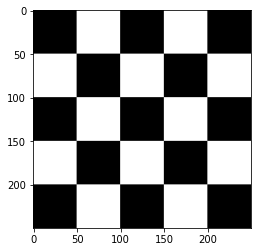

In [4]:
img, corners = generate_checkered(sq_size=50,qtd_x=5,qtd_y=5)
show(img)

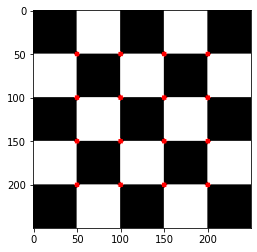

In [5]:
img_copy = img.copy()
for tup in corners:
    drawPoint(img_copy, (tup[0],tup[1]), radius=3)
show(img_copy)

In [6]:
def plot_results(title, xlabel, xvals, 
                 own_rms, cv_rms, own_qtd, cv_qtd, 
                 own_miss, cv_miss, own_spur, cv_spur):
    """
    Plots the four charts about RMS, Quantity of Reported Corners, 
    Missed and Spurious Corners
    """
    # Plotting the results
    fig, axs = plt.subplots(2,2, figsize=(12,10))
    fig.suptitle(title)

    # RMS
    axs[0,0].plot(xvals, own_rms)
    axs[0,0].plot(xvals, cv_rms)
    axs[0,0].set(title="Original Noisy Image",xlabel=xlabel,ylabel="RMS")
    axs[0,0].legend(["Own","OpenCV"])

    # Qtd. Reported Corners
    axs[0,1].plot(xvals, np.log(own_qtd))
    axs[0,1].plot(xvals, np.log(cv_qtd))
    axs[0,1].set(title="Qtd. Reported Corners",xlabel=xlabel,ylabel="ln(# Reported Corners)")
    axs[0,1].legend(["Own","OpenCV"])

    # Missed Corners
    axs[1,0].plot(xvals, own_miss)
    axs[1,0].plot(xvals, cv_miss)
    axs[1,0].set(title="Missed Corners",xlabel=xlabel,ylabel="# Missed Corners")
    axs[1,0].legend(["Own","OpenCV"])
#     axs[1,0].set_ylim([-.5,5])

    # Spurious Corners
    arr1 = np.array(own_spur)
    arr2 = np.array(cv_spur)
    axs[1,1].plot(xvals, np.log(arr1, where=arr1>0))
    axs[1,1].plot(xvals, np.log(arr2, where=arr2>0) )
    axs[1,1].set(title="Spurious Corners",xlabel=xlabel,ylabel="ln(# Spurious Corners)")
    axs[1,1].legend(["Own","OpenCV"]);

## Algoritmo
A seguir a implementação do algoritmo de detecção de harris pedido

In [7]:
def gauss(img, stddev=1):
    """
    Adds gaussian noise to an image
    """
    mean = 0
    gauss = np.random.normal(mean,stddev,img.shape)
    gauss = gauss.reshape(img.shape[0],img.shape[1]).astype('uint8')
    noisy = img + gauss
    return noisy

In [8]:
def nonMaxSup(img, size):
    """
    Applies non-max suppression in the already thresholded image.
    Uses a sliding window method with passed size
    """
    row, col = img.shape
    newimage = img.copy()
    for i in range(row-size+1):
        for j in range(col-size+1):
            # Get window
            window = newimage[i:i+size,j:j+size]
            # Get max in the window
            maxWindow = np.max(window)
            # Eliminate all non max in the window
            for a in range(size):
                for b in range(size):
                    if (newimage[i+a,j+b] < maxWindow):
                        newimage[i+a,j+b] = 0
    return newimage

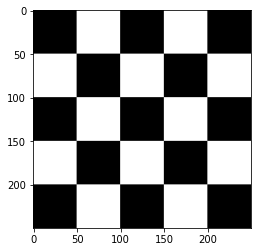

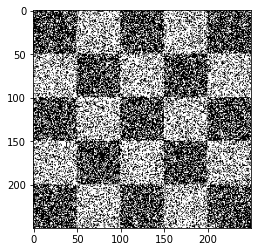

In [9]:
# Convert image to grayscale and add Gaussian Noise
img, corners = generate_checkered(sq_size=50,qtd_x=5,qtd_y=5)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
show(img)
noise = gauss(img,2)
show(noise)

In [10]:
def harris(img, thresh_perc=0.1, non_max_window_perc=0.01, prints=False):
    """
    Apply harris detector to detect corners in an image.
    thresh_perc: percentage of maximum used for thresholding
    non_max_window_perc: percentage of image width (or height) 
        to be used as window for non-max suppresion
    """    
    # Sobel to find the derivative in each direction
    sobelx = cv.Sobel(img, cv.CV_64F,1,0,ksize=5)
    sobely = cv.Sobel(img, cv.CV_64F,0,1,ksize=5)
    
    # Find 2D derivatives
    Ix2 = sobelx * sobelx
    Iy2 = sobely * sobely
    Ixy = sobelx * sobely
    
    # Sum in window 5x5 using Gaussian Filtering
    Sx2 = cv.GaussianBlur(Ix2,(5,5),sigmaX=1,sigmaY=1)
    Sy2 = cv.GaussianBlur(Iy2,(5,5),sigmaX=1,sigmaY=1)
    Sxy = cv.GaussianBlur(Ixy,(5,5),sigmaX=1,sigmaY=1)
    
    # Compute corner response (R) and M matrix for each pixel, using fixed k
    k = 0.04
    R = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # Compute M matrix at pixel (i,j)
            M = np.array([[Sx2[i][j], Sxy[i][j]],
                          [Sxy[i][j], Sy2[i][j]]])
            R[i,j] = np.linalg.det(M) - k*(np.trace(M))**2
    
    # Threshold the values
    ret,thresh1 = cv.threshold(R,thresh_perc*R.max(),255,cv.THRESH_TOZERO)
    
    # Non-max suppresion
    w_size = int(non_max_window_perc*(max(img.shape[0],img.shape[1])))
    nonmax = nonMaxSup(thresh1, w_size)
    if (prints):
        # Usando o dilate porque senão não conseguimos ver na visualização
        dst = cv.dilate(nonmax,None)
        plt.title("Own")
        plt.imshow(dst, cmap="gray")
        plt.show()
    return nonmax

In [11]:
mine = harris(img, True)

## Funções para Comparações
Vamos comparar o desempenho da implementação apresentada com a presente na OpenCV

In [12]:
def closest_node_distance(node, node_list):
    """
    Finds the closest point in the list to the passed point 
    and returns the square distance between these two
    Adapted from: https://codereview.stackexchange.com/questions/28207/finding-the-closest-point-to-a-list-of-points
    """
    node_list = np.asarray(node_list)
    dist_2 = np.sum((node_list - node)**2, axis=1)
    return min(dist_2), np.argmin(dist_2)

A medida RMS é a raiz quadrada da distância euclidiana de onde o corner foi detectado para o local exato, o qual só pode ser obtido visto que as imagens de base são artificiais. O algoritmo que computa essa medida, para cada corner verdadeiro, procura qual o corner reportado pelo algoritmo de detecção é mais próximo dele e computa a distância euclidiana até esse corner reportado. 

In [13]:
def rms(pred_corners_img,true_corners):
    """
    Computes Root Mean Squared (RMS) from obtained corners and the true corners.
    """
    s2 = 0
    counter = 0
    for i in range(pred_corners_img.shape[0]):
        for j in range(pred_corners_img.shape[1]):
            if (pred_corners_img[i][j] != 0):
                corner = (i,j)
                dist_2, idx = closest_node_distance(corner, true_corners)
                s2 += dist_2
                counter += 1
            else:
                pass
    s = s2/counter
    return np.sqrt(s)

As definições de um corner não detectado (missed) e um corner espúrio (spurious) utilizadas são apresentadas a seguir. 

Um corner não detectado significa que não foi reportado qualquer corner pelo algoritmo próximo ao ponto exato do corner, dentro de uma tolerância. Essa tolerância, por padrão, é 5% da altura ou comprimento da imagem (o que for maior). Corners não detectados são, naturalmente, os falsos negativos.  

Um corner espúrio é um corner que foi reportado, mas não há qualquer corner verdadeiro próximo dele, dentro da mesma tolerância. Corners espúrios são falsos positivos.

In [14]:
def missed_spurious(pred_corners_img,true_corners, tolerance=None):
    """
    Finds missed and spurious corners. 
    Missed: there is no reported corner near a true corner within a tolerance
    Spurious: there is no true corner near reported corner within a tolerance
    Tolerance defaults to 5% of image width or height (the biggest of them)
    """
    # Sets tolerance to default if not passed
    if tolerance is None:
        tolerance = 0.05*max(pred_corners_img.shape[0],pred_corners_img.shape[1])
    
    # Gets all predicted corners in a list
    p_corners_list = []
    for i in range(pred_corners_img.shape[0]):
        for j in range(pred_corners_img.shape[1]):
            if (pred_corners_img[i][j] != 0):
                corner = (i,j)
                p_corners_list.append(corner)
            else:
                pass
    
    # Spurious: no true corner near a reported corner
    spurious = 0
    for p_corner in p_corners_list:
        dist2, _ = closest_node_distance(p_corner, true_corners)
        dist = np.sqrt(dist2)
        if (dist > tolerance):
            # If nearest true corner is not within tolerance,
            # It's a spurious
            spurious += 1

    # Missed: no predicted corner near a true corner
    missed = 0
    for t_corner in true_corners:
        dist2, _ = closest_node_distance(t_corner, p_corners_list)
        dist = np.sqrt(dist2)
        if (dist > tolerance):
            # If nearest true corner is not within tolerance,
            # It's a spurious
            missed += 1
            
    return missed, spurious

### Exemplo da Tolerância
Exemplo da área ao redor do corner que ainda é aceita antes de ser apontado um corner espúrio. Vamos rodar o algoritmo e manualmente adicionar uma área ao redor de uma quina como se tivesse sido reportada como uma.

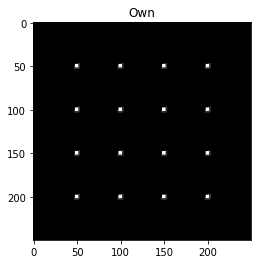

In [15]:
# Generating grayscale checkered pattern
img, corners = generate_checkered(sq_size=50,qtd_x=5,qtd_y=5)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
noise = gauss(img,.01)
img = noise

# Applying implemented Harris detector
pred_corners = harris(img, prints=True);

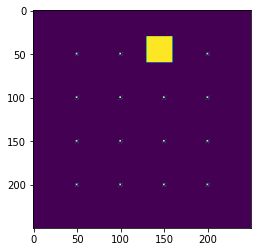

In [16]:
# Mistakenly reporting a big square with a lot of corners
copy = pred_corners.copy()
m = copy.max()
for i in range(30):
    for j in range(30):
        copy[30+i][130+j] = m
plt.imshow(copy)

Agora, vamos fazer a detecção dos corners espúrios usando parte do algoritmo da função _missed_spurious_. Aqui, quando encontrarmos algum corner desse tipo, vamos zerar essa posição. Dessa forma, ao final, do quadrado manualmente adicionado, restará apenas a área que está dentro da tolerância do ponto correto do corner.

In [17]:
# This is part of 'missed_spurious' function
pred_corners = copy
spur = copy.copy()
true_corners = corners

# Sets tolerance to default
tolerance = 0.01*max(pred_corners.shape[0],pred_corners.shape[1])

# Gets all predicted corners in a list
p_corners_list = []
for i in range(pred_corners.shape[0]):
    for j in range(pred_corners.shape[1]):
        if (pred_corners[i][j] != 0):
            corner = (i,j)
            p_corners_list.append(corner)
        else:
            pass

# Spurious: no true corner near a reported corner
spurious = 0
for p_corner in p_corners_list:
    dist2, _ = closest_node_distance(p_corner, true_corners)
    dist = np.sqrt(dist2)
    if (dist > tolerance):
        # If nearest true corner is not within tolerance, it's a spurious one
        # Lets erase this wrong corner
        spur[p_corner[0]][p_corner[1]] = 0
        spurious += 1

In [18]:
# How many spurious corners were found
print(spurious)

909


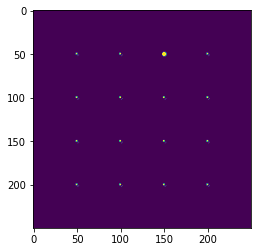

In [19]:
# Valid corner area within tolerance
plt.imshow(spur);

## Versão do OpenCV
Usando como base a utilização da documentação da OpenCV, cria-se uma função para fazer a detecção de corners com o algoritmo nativo da biblioteca. Como no referido exemplo, aplica-se um threshold e, além disso, aplica-se também o supressor de não-máximos.

In [20]:
def opencv_harris(img, thresh_perc=0.1, non_max_window_perc=0.01, prints=False):
    """
    Applies the native OpenCV implementation of Harris Corner Detector
    thresh_perc: percentage of maximum used for thresholding
    non_max_window_perc: percentage of image width (or height) 
        to be used as window for non-max suppresion
    """
    # OpenCV Harris Detector, using the same parameters:
    # Neighborhood of 5x5
    # Sobel detector of 3x3
    # k=0.04
    dst = cv.cornerHarris(img,5,3,k=0.04)

    # Threshold 
    # Same threshold value (10% of max)
    ret,thresh1 = cv.threshold(dst,thresh_perc*dst.max(),255,cv.THRESH_TOZERO)
    
    # NonMax Suppresion
    w_size = int(non_max_window_perc*(max(img.shape[0],img.shape[1])))
    nonmax = nonMaxSup(thresh1, w_size)
    
    if (prints):
        dst = cv.dilate(nonmax,None)
        plt.imshow(dst, cmap="gray")
        plt.title("OpenCV")
        plt.show()
    return nonmax

## Otimização de Parâmetros

É importante escolher bons valores para o limiar de threshold e também o tamanho da janela de supressão de não-máximos

### Threshold

Utilizando o $\sigma=1$, vamos avaliar qual o melhor threshold para ser utilizado. Em outras palavras, vamos fixar um parâmetro para otimizar um segundo.

In [21]:
# Imagem base
img, corners = generate_checkered(sq_size=50,qtd_x=5,qtd_y=5)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

Vamos guardar as imagens geradas bem como os descritores RMS, corners não detectados e corners espúrios.

In [22]:
# Store threshold values
thresh_vals = []
original_imgs = []

# Store implemented detector's results
own_rms = []
own_miss = []
own_spur = []
own_qtd = []
own_img_results = []

# Store OpenCV's detector's results
cv_rms = []
cv_miss = []
cv_spur = []
cv_qtd = []
cv_img_results = []

# Loop parameters
MIN = 0.01
MAX = 0.51
STEP = .01
PRINT = False

# Keep sigma at 1.0
stddev = 1.0

In [23]:
for thresh in np.arange(MIN,MAX,STEP):
    print(f"Iteration: {int(thresh/STEP)}/{int(MAX/STEP)-1}, Threshold={round(thresh,2)}")
    noise = gauss(img,stddev)
    thresh_vals.append(thresh)
    original_imgs.append(noise)
    
    # Applying the detectors
    own = harris(noise, thresh_perc=thresh, prints=PRINT)
    own_img_results.append(own)
    opencv = opencv_harris(noise, thresh_perc=thresh, prints=PRINT)
    cv_img_results.append(opencv)
    
    # RMS
    own_rms.append(rms(own, corners))
    cv_rms.append(rms(opencv, corners))
    
    # Spurious and Missed Corners
    miss, spur = missed_spurious(own, corners)
    own_miss.append(miss)
    own_spur.append(spur)
    miss, spur = missed_spurious(opencv, corners)
    cv_miss.append(miss)
    cv_spur.append(spur)
    
    # Qtd. of corners found
    own_qtd.append(np.count_nonzero(own))
    cv_qtd.append(np.count_nonzero(opencv))

Iteration: 1/50, Threshold=0.01
Iteration: 2/50, Threshold=0.02
Iteration: 3/50, Threshold=0.03
Iteration: 4/50, Threshold=0.04
Iteration: 5/50, Threshold=0.05
Iteration: 6/50, Threshold=0.06
Iteration: 6/50, Threshold=0.07
Iteration: 8/50, Threshold=0.08
Iteration: 9/50, Threshold=0.09
Iteration: 9/50, Threshold=0.1
Iteration: 11/50, Threshold=0.11
Iteration: 12/50, Threshold=0.12
Iteration: 13/50, Threshold=0.13
Iteration: 14/50, Threshold=0.14
Iteration: 15/50, Threshold=0.15
Iteration: 16/50, Threshold=0.16
Iteration: 17/50, Threshold=0.17
Iteration: 18/50, Threshold=0.18
Iteration: 19/50, Threshold=0.19
Iteration: 20/50, Threshold=0.2
Iteration: 21/50, Threshold=0.21
Iteration: 22/50, Threshold=0.22
Iteration: 23/50, Threshold=0.23
Iteration: 24/50, Threshold=0.24
Iteration: 25/50, Threshold=0.25
Iteration: 26/50, Threshold=0.26
Iteration: 27/50, Threshold=0.27
Iteration: 28/50, Threshold=0.28
Iteration: 29/50, Threshold=0.29
Iteration: 30/50, Threshold=0.3
Iteration: 31/50, Thres

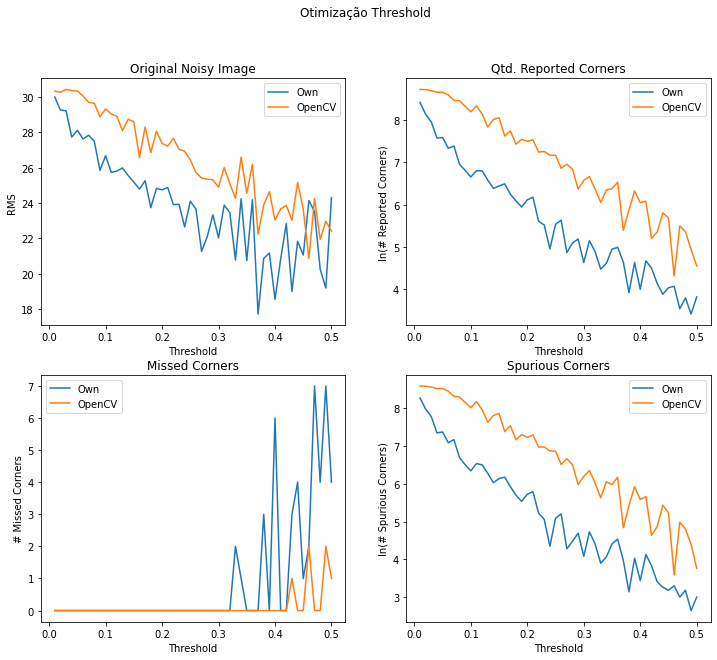

In [24]:
plot_results("Otimização Threshold", "Threshold", thresh_vals,
             own_rms, cv_rms, own_qtd, cv_qtd, 
             own_miss, cv_miss, own_spur, cv_spur)

Podemos ver que quanto maior a porcentagem de threshold, o RMS diminui, bem como a quantidade total de corners reportados e os espúrios. Contudo, a partir de 0.3, percebe-se que o algoritmo implementado começa a apresentar problemas com corners não detectados. Desse modo, vamos utilizar o valor de threshold de 0.3.

### Tamanho da janela de supressão de não-máximos

Tal como foi feito com o limiar, vamos definir o tamanho da janela utilizado na supressão de não-máximos. Esse parâmetro influencia tanto nos resultados quanto no tempo de execução. Vamos manter $\sigma=1$ e o threshold em $0.3$

In [25]:
# Imagem base
img, corners = generate_checkered(sq_size=50,qtd_x=5,qtd_y=5)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [26]:
# Store window values
window_vals = []
original_imgs = []

# Store implemented detector's results
own_rms = []
own_miss = []
own_spur = []
own_qtd = []
own_img_results = []

# Store OpenCV's detector's results
cv_rms = []
cv_miss = []
cv_spur = []
cv_qtd = []
cv_img_results = []

# Loop parameters
MIN = 0.01
MAX = 0.11
STEP = .01
PRINT = False

# Keep sigma at 1.0
stddev = 1.0
thresh = 0.3

In [27]:
for window in np.arange(MIN,MAX,STEP):
    print(f"Iteration: {int(window/STEP)}/{int(MAX/STEP)-1}, Window={round(window,2)}")
    noise = gauss(img,stddev)
    window_vals.append(window)
    original_imgs.append(noise)
    
    # Applying the detectors
    own = harris(noise, thresh_perc=thresh, non_max_window_perc=window, prints=PRINT)
    own_img_results.append(own)
    opencv = opencv_harris(noise, thresh_perc=thresh, non_max_window_perc=window, prints=PRINT)
    cv_img_results.append(opencv)
    
    # RMS
    own_rms.append(rms(own, corners))
    cv_rms.append(rms(opencv, corners))
    
    # Spurious and Missed Corners
    miss, spur = missed_spurious(own, corners)
    own_miss.append(miss)
    own_spur.append(spur)
    miss, spur = missed_spurious(opencv, corners)
    cv_miss.append(miss)
    cv_spur.append(spur)
    
    # Qtd. of corners found
    own_qtd.append(np.count_nonzero(own))
    cv_qtd.append(np.count_nonzero(opencv))

Iteration: 1/10, Window=0.01
Iteration: 2/10, Window=0.02
Iteration: 3/10, Window=0.03
Iteration: 4/10, Window=0.04
Iteration: 5/10, Window=0.05
Iteration: 6/10, Window=0.06
Iteration: 6/10, Window=0.07
Iteration: 8/10, Window=0.08
Iteration: 9/10, Window=0.09
Iteration: 9/10, Window=0.1


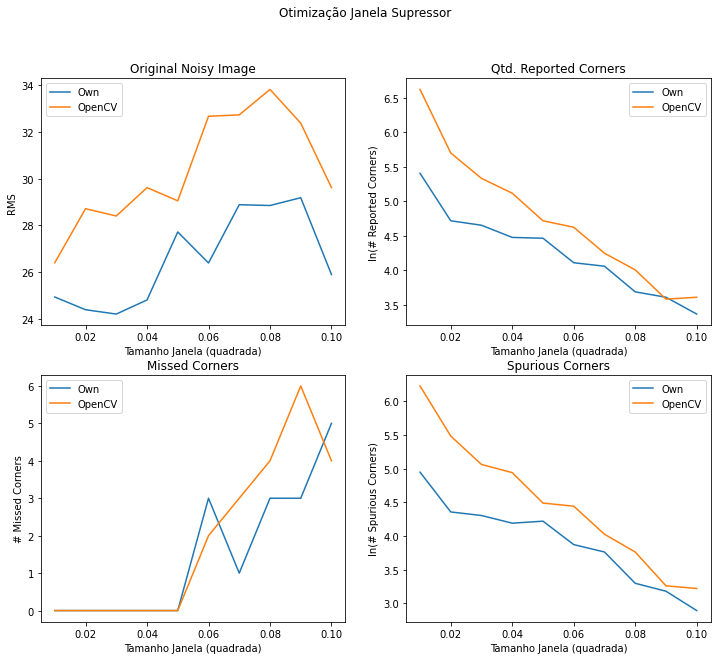

In [28]:
plot_results("Otimização Janela Supressor", "Tamanho Janela (quadrada)", window_vals,
             own_rms, cv_rms, own_qtd, cv_qtd, 
             own_miss, cv_miss, own_spur, cv_spur)

Usando uma análise semelhante, vemos que, apesar de que a quantidade de corners totais e de corners espúrios diminui com o aumento do tamanho da janela. Contudo, o RMS também aumenta, conjuntamente com a quantidade de corners não detectados. Assim, vamos usar a janela em torno de $0.04$, último valor antes do aumento da quantidade de corners não detectados e também antes de que o RMS atinja o patamar de $30$.

## Resultados e Discussão

### Resultados

Após as devidas escolhas de parâmetros, vamos gerar os resultados de Root Mean Square (RMS), corners não detectados (missed) e corners espúrios (spurious). Utilizaremos o threshold de $0.3$ e a janela de $0.04$

In [29]:
# Imagem base
img, corners = generate_checkered(sq_size=50,qtd_x=5,qtd_y=5)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [30]:
stds = []
original_imgs = []

own_rms = []
own_miss = []
own_spur = []
own_qtd = []
own_img_results = []

cv_rms = []
cv_miss = []
cv_spur = []
cv_qtd = []
cv_img_results = []

MIN = .2
MAX = 2.2
STEP = .2
PRINT = False

thresh = 0.3
non_max = 0.04

In [31]:
for stddev in np.arange(MIN,MAX,STEP):
    print(f"Iteration: {int(stddev/STEP)}/{int(MAX/STEP)-1}, Sigma={round(stddev,2)}")
    noise = gauss(img,stddev)
    stds.append(stddev)
    original_imgs.append(noise)
    
    # Applying the detectors
    own = harris(noise, thresh_perc=thresh, non_max_window_perc=non_max, prints=PRINT)
    own_img_results.append(own)
    opencv = opencv_harris(noise, thresh_perc=thresh, non_max_window_perc=non_max, prints=PRINT)
    cv_img_results.append(opencv)
    
    # RMS
    own_rms.append(rms(own, corners))
    cv_rms.append(rms(opencv, corners))
    
    # Spurious and Missed Corners
    miss, spur = missed_spurious(own, corners)
    own_miss.append(miss)
    own_spur.append(spur)
    miss, spur = missed_spurious(opencv, corners)
    cv_miss.append(miss)
    cv_spur.append(spur)
    
    # Qtd. of corners found
    own_qtd.append(np.count_nonzero(own))
    cv_qtd.append(np.count_nonzero(opencv))

Iteration: 1/10, Sigma=0.2
Iteration: 2/10, Sigma=0.4
Iteration: 3/10, Sigma=0.6
Iteration: 4/10, Sigma=0.8
Iteration: 5/10, Sigma=1.0
Iteration: 5/10, Sigma=1.2
Iteration: 7/10, Sigma=1.4
Iteration: 8/10, Sigma=1.6
Iteration: 9/10, Sigma=1.8
Iteration: 10/10, Sigma=2.0


Nesse momento, podemos ter um feedback visual do desempenho dos dois algoritmos.

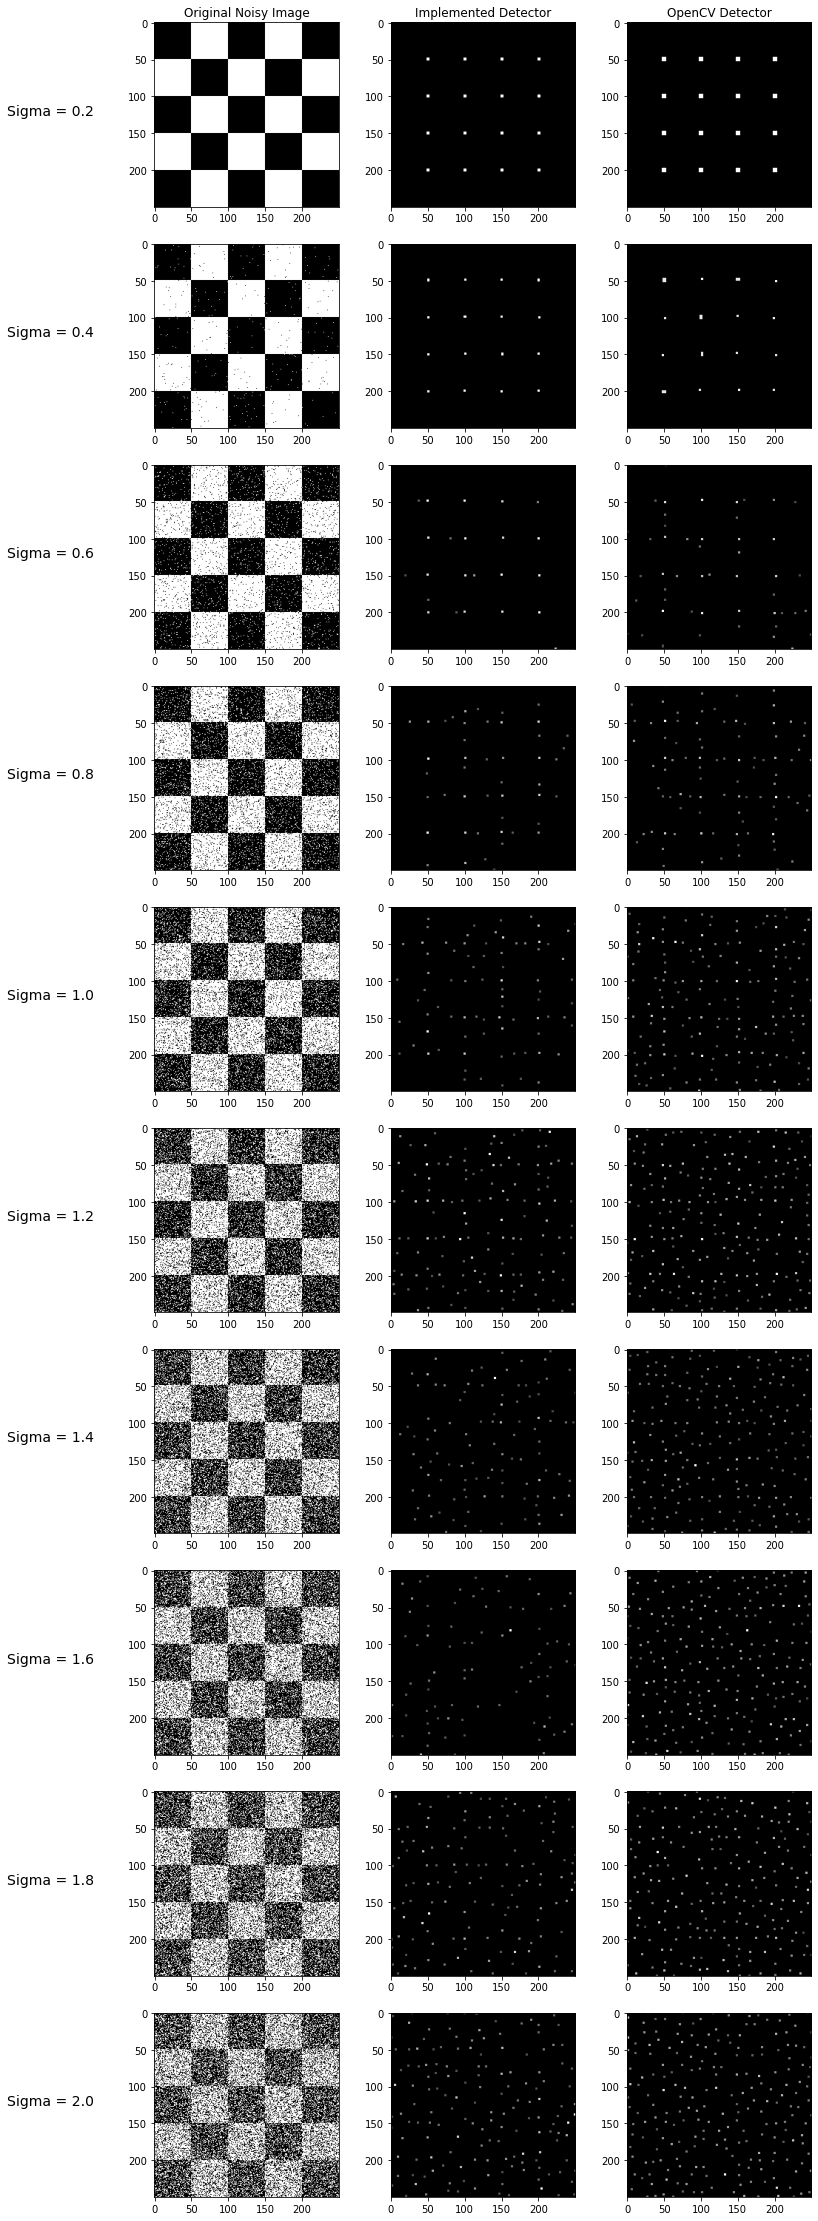

In [32]:
# Comparing the results
# NOTE: the image passes through a cv.dilate so we can see it better

fig, axs = plt.subplots(int(MAX/STEP)-1,3,figsize=(12,40))

i = 0
for stddev in np.arange(MIN,MAX,STEP):
    axs[i,0].imshow(original_imgs[i], cmap="gray")
    axs[i,1].imshow(cv.dilate(own_img_results[i],None) , cmap="gray")
    axs[i,2].imshow(cv.dilate(cv_img_results[i], None), cmap="gray")
    axs[i,0].text(-200, original_imgs[i].shape[0]//2, f"Sigma = {round(stddev,2)}", fontsize=14)
    
    if (i == 0):
        axs[i,0].set(title="Original Noisy Image")
        axs[i,1].set(title="Implemented Detector")
        axs[i,2].set(title="OpenCV Detector")
    i += 1

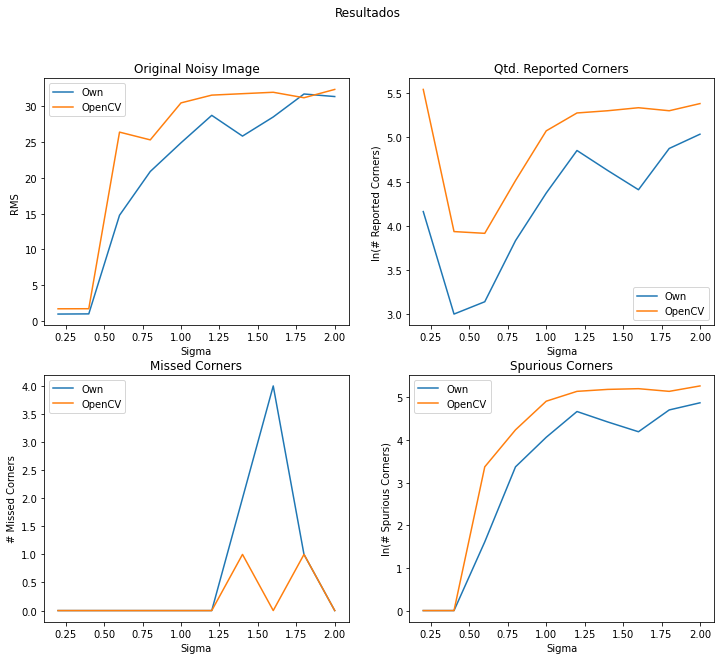

In [33]:
plot_results("Resultados", "Sigma", stds,
             own_rms, cv_rms, own_qtd, cv_qtd, 
             own_miss, cv_miss, own_spur, cv_spur)

### Discussão
Após os resultados, é possível tecer alguns comentários. 

#### Desvio-padrão

A partir de aproximadamente um desvio padrão de 1 unidade, os detectores começam a reportar muitos corners espalhado e isso causa um aumento do RMS. Para se ter uma ideia, se usarmos o ruído gaussiano apenas como um resultado de detecção de corners, vamos ter um RMS de cerca de 30. Isso nos mostra que, a partir desse desvio padrão, os algoritmos sofrem bastante com o ruído

30.383942798375735

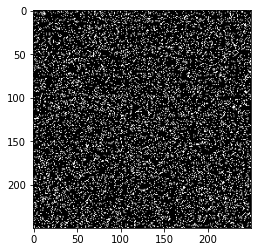

In [34]:
# 30 é o RMS do ruído gaussiano
gaussNoise = np.random.normal(0,1,img.shape)
gaussNoise = gaussNoise.reshape(img.shape[0],img.shape[1]).astype('uint8')
plt.imshow(gaussNoise, cmap="gray")
rms(gaussNoise,corners)

#### Corners Espúrios e Não-detectados

Continuando a discussão do tópico anterior, com o aumento do ruído, os algoritmos sofrem bastante influência e começam a reportar muitos corners. São tantos que decidiu-se usar a escala logarítmica tanto para a quantidade de quinas encontradas quanto as quinas espúrias. A partir do desvio-padrão de 1, eles começam a reportar bastantes corners espúrios, espalhados por toda o espaço da imagem, tendo um desempenho próximo ao ruído gaussiano, por exemplo, como vimos. Com esse espalhamento, a quantidade de corners não detectados também aumenta.

#### Tempo de Execução

Para uma janela pequena do supressor de não-máximos, temos que a implementação feita aqui é mais lenta que a da OpenCV. Contudo, com uma janela maior, é esperado que o tempo aumente. Num teste bem simples, os tempos com a janela maior ficaram mais próximos.

In [35]:
# Generating an image
img, corners = generate_checkered(sq_size=50,qtd_x=5,qtd_y=5)
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
noise = gauss(img,.5)

In [36]:
%%time
# Non-Max Suppresion Window of 1%
pred_corners = harris(noise, non_max_window_perc=0.01, prints=False)

CPU times: user 1.26 s, sys: 0 ns, total: 1.26 s
Wall time: 1.26 s


In [37]:
%%time
# Non-Max Suppresion Window of 1%
pred_corners = opencv_harris(noise, non_max_window_perc=0.01, prints=False)

CPU times: user 316 ms, sys: 20 µs, total: 316 ms
Wall time: 314 ms


In [38]:
%%time
# Non-Max Suppresion Window of 10%
pred_corners = harris(noise, non_max_window_perc=0.1, prints=False)

CPU times: user 8.02 s, sys: 20.2 ms, total: 8.04 s
Wall time: 7.97 s


In [39]:
%%time
# Non-Max Suppresion Window of 10%
pred_corners = opencv_harris(noise, non_max_window_perc=0.1, prints=False)

CPU times: user 7.56 s, sys: 20.1 ms, total: 7.58 s
Wall time: 7.53 s
